In [9]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import keras_tuner as kt
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import random
import seaborn as sn
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Juane/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/Juane/Sentinel2LULC_Test.zip" -d "/content"

In [2]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [3]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)

Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [ ]:
## Estimación de los hiperparámetros del compilador

def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  augmentation = Sequential([
        RandomFlip()
  ])
  base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')
  base_model.trainable = False
  entrada = Input(shape=(224,224,3))
  prediction_layer = Dense(29, activation="softmax")
  model = Sequential([
    entrada,
    augmentation,
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    prediction_layer
  ])

  # Tuneamos el learning rate y el optimizador
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,0.1,
                                                        0.2, 0.3])
  hp_amsgrad = hp.Choice('amsgrad', values=[True,False])
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate,amsgrad=hp_amsgrad),
                loss=SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  return model

# Instanciamos el tuner
tuner = kt.Hyperband(model_builder, 
                     objective='val_accuracy', 
                     max_epochs=25,
                     factor=3, 
                     directory="/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/",
                     project_name='khyperbandEfficientNetB2')

print(tuner.search_space_summary())

# Ejecutamos el tuner
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(training,validation_data=validation,epochs=25, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]

print(best_hp.get('learning_rate'))
print(best_hp.get('amsgrad'))

Trial 18 Complete [00h 17m 02s]
val_accuracy: 0.7588894367218018

Best val_accuracy So Far: 0.7588894367218018
Total elapsed time: 01h 54m 20s
INFO:tensorflow:Oracle triggered exit


Epoch 1/100
257/257 [==============================] - 136s 445ms/step - loss: 1.6755 - accuracy: 0.5097 - val_loss: 1.3244 - val_accuracy: 0.6230
Epoch 2/100
257/257 [==============================] - 109s 423ms/step - loss: 1.1574 - accuracy: 0.6312 - val_loss: 1.0147 - val_accuracy: 0.6542
Epoch 3/100
257/257 [==============================] - 109s 423ms/step - loss: 1.0183 - accuracy: 0.6708 - val_loss: 0.9498 - val_accuracy: 0.6805
Epoch 4/100
257/257 [==============================] - 109s 422ms/step - loss: 0.9347 - accuracy: 0.6945 - val_loss: 0.9559 - val_accuracy: 0.6985
Epoch 5/100
257/257 [==============================] - 109s 422ms/step - loss: 0.8811 - accuracy: 0.7066 - val_loss: 0.9495 - val_accuracy: 0.6965
Epoch 6/100
257/257 [==============================] - 109s 424ms/step - loss: 0.8416 - accuracy: 0.7180 - val_loss: 0.8851 - val_accuracy: 0.7131
Epoch 7/100
257/257 [==============================] - 109s 422ms/step - loss: 0.8222 - accuracy: 0.7319 - val_loss: 0

2022/03/19 19:53:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


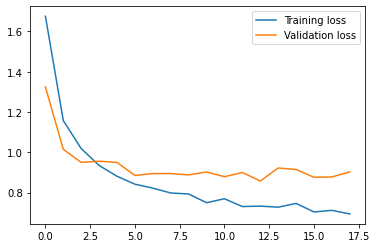

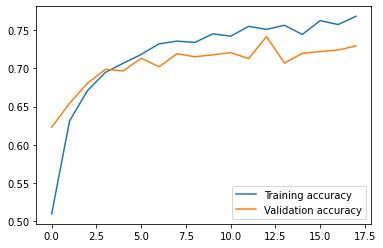

In [4]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip()
])


## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB4(include_top=False,
                                                  weights='imagenet',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=0.001, amsgrad=0)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB4 con DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/100
257/257 [==============================] - 425s 2s/step - loss: 1.5029 - accuracy: 0.6004 - val_loss: 1.5515 - val_accuracy: 0.5611
Epoch 2/100
257/257 [==============================] - 394s 2s/step - loss: 0.7110 - accuracy: 0.7817 - val_loss: 0.4996 - val_accuracy: 0.8232
Epoch 3/100
257/257 [==============================] - 393s 2s/step - loss: 0.5219 - accuracy: 0.8238 - val_loss: 0.4059 - val_accuracy: 0.8646
Epoch 4/100
257/257 [==============================] - 392s 2s/step - loss: 0.3946 - accuracy: 0.8672 - val_loss: 0.3936 - val_accuracy: 0.8656
Epoch 5/100
257/257 [==============================] - 393s 2s/step - loss: 0.3363 - accuracy: 0.8837 - val_loss: 0.3322 - val_accuracy: 0.8880
Epoch 6/100
257/257 [==============================] - 393s 2s/step - loss: 0.3082 - accuracy: 0.8957 - val_loss: 0.3332 - val_accuracy: 0.8889
Epoch 7/100
257/257 [==============================] - 392s 2s/step - loss: 0.2413 - accuracy: 0.9132 - val_loss: 0.3020 - val_accuracy:

2022/03/19 21:19:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


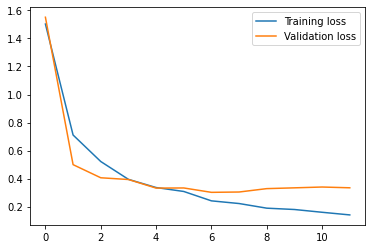

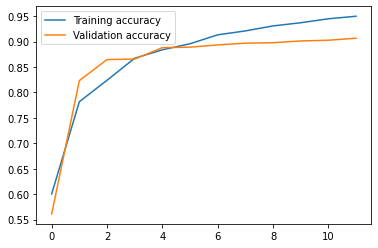

In [5]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
  for layer in model.layers[-23:]:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = True

  opt = Adam(learning_rate=1e-4)
  model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
              metrics=['accuracy'])
  
unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [6]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [7]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB4_ImageNet.csv', index=False)
files.download('EfficientNetB4_ImageNet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

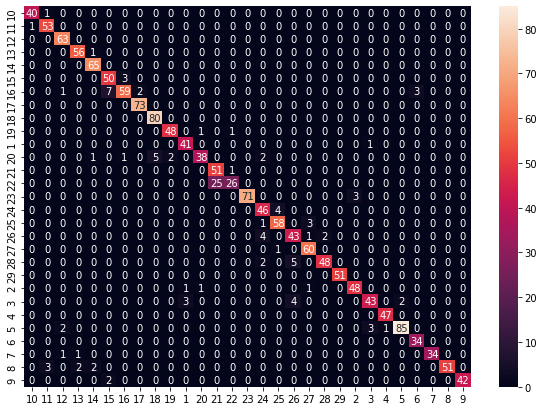

In [10]:
## Sacamos la matriz de confusion

clases = []
dirname = sorted(os.listdir("Sentinel2LULC_Test"))
for names in dirname:
  clases.append(names.split('_')[0])

clases = [int(x) for x in clases]

indexes = [i for i in range(10,20)]+[1]+[i for i in range(20,30)]+[i for i in range(2,10)]

matrix = confusion_matrix(clases, list(classes),labels=indexes)

df_cm = pd.DataFrame(matrix, index = indexes, columns = indexes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)